In [1]:
import os
import shutil
import pickle
import sys
import zipfile 

### 数据下载与预处理
* 数据解压为train 和test
* 数据依照cat 和dog 移动到train2 文件夹，清空原本、文件夹

In [2]:
# 解压kaggle数据
#完成一次后，下次不需要再解压
def load_pics(fpath):
    fz = zipfile.ZipFile(fpath,'r')
    for file in fz.namelist():
        fz.extract(file)
    fz.close()
load_pics('train.zip')
load_pics('test.zip')

In [4]:
from sklearn.model_selection import train_test_split
import seaborn as sns

train_files = os.listdir('train')
train, valid = train_test_split(train_files, test_size=0.1, random_state=42)

train_cats=filter(lambda x: x.split('.')[0]== 'cat', train)
train_dogs=filter(lambda x: x.split('.')[0]== 'dog', train)
valid_cats=filter(lambda x: x.split('.')[0]== 'cat', valid)
valid_dogs=filter(lambda x: x.split('.')[0]== 'dog', valid)

def create_cache_train(filename):
    if not os.path.exists(filename):
        os.makedirs(filename+'/cats')
        os.makedirs(filename+'/dogs') 
    else:
        print("Please check your dataset flie.")
        
create_cache_train('train3')
create_cache_train('valid3')

In [5]:
for file in train_cats:
    shutil.move('train/' + file,'train3/cats/' + file)
for file in train_dogs:
    shutil.move('train/' + file,'train3/dogs/' + file)
for file in valid_cats:
    shutil.move('train/' + file,'valid3/cats/' + file)
for file in valid_dogs:
    shutil.move('train/' + file,'valid3/dogs/' + file)

In [6]:
os.makedirs('test3'+'/test')
for file in os.listdir('test'):
    shutil.move('test/' + file,'test3/test/' + file)

### 完成预处理，文件保存好后，下次不需要再预处理

------------------------------------------------------------------------------------------------------------------------------------

### 分别使用单独的模型训练：
* Res50

#### 预处理数据
    由于之前已经把数据分成了dogs 文件夹和 cats 文件夹，这里就可以使用Keras中的 ImageDataGenerator 来自动处理训练数据：

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

Using TensorFlow backend.


In [1]:
#from keras.preprocessing.image import ImageDataGenerator
batch_size=16
image_size = (224,224)

train_gen = ImageDataGenerator()
train_generator = train_gen.flow_from_directory('train3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                                class_mode='binary'
                                               )
valid_gen = ImageDataGenerator()
valid_generator = train_gen.flow_from_directory('valid3',
                                               target_size=image_size,  # all images will be resized to 224x224
                                               batch_size=batch_size,
                                               class_mode='binary')
test_gen = ImageDataGenerator()
test_generator = train_gen.flow_from_directory('test3',
                                              target_size=image_size,  # all images will be resized to 224x224
                                              batch_size=batch_size,
                                              class_mode=None)

x_train = train_generator
x_valid = valid_generator
x_test = test_generator

Using TensorFlow backend.


Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


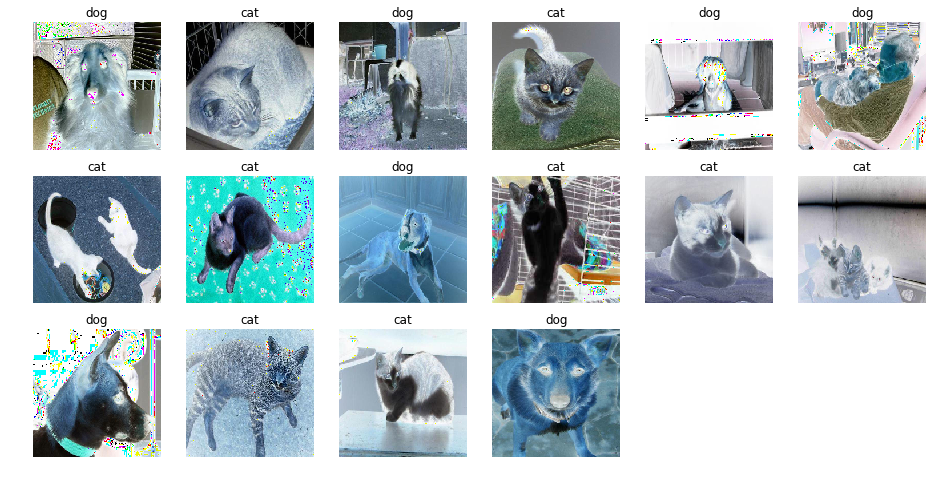

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

index, batch = train_generator.next()

plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(index, batch)):
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
    plt.imshow(img, interpolation="nearest")

### 引入Res50模型：

In [13]:
#from keras.models import *
#from keras.layers import *
#from keras.applications import *
#from keras.preprocessing.image import *

base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(base_model.input, x)

In [4]:
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [5]:
from keras.callbacks import TensorBoard

tensorBoard = TensorBoard(log_dir = './logs')
model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator//batch_size,
        epochs = 4,
        validation_data = valid_generator,
        validation_steps = valid_generator//batch_size,
        callbacks=[tensorBoard])

Epoch 1/4
87/87 [==============================] - 17s 193ms/step - loss: 0.3312 - acc: 0.8585 - val_loss: 0.1943 - val_acc: 0.9444
Epoch 2/4
87/87 [==============================] - 16s 179ms/step - loss: 0.1569 - acc: 0.9476 - val_loss: 0.1055 - val_acc: 0.9583
Epoch 3/4
87/87 [==============================] - 16s 179ms/step - loss: 0.1517 - acc: 0.9476 - val_loss: 0.1511 - val_acc: 0.9306
Epoch 4/4
87/87 [==============================] - 16s 180ms/step - loss: 0.1409 - acc: 0.9432 - val_loss: 0.0682 - val_acc: 0.9722


In [6]:
model.save('./res50_result')

In [3]:
model = load_model('res50_result')

In [3]:
from tqdm import *
import cv2

image_size = (224,224)
def get_image(index):
    img = cv2.imread('test3/test/%d.jpg' % index)
    img = cv2.resize(img, image_size)
    img.astype(np.float32)
    return img

test_num = 12500

In [4]:
x_test = np.zeros((test_num, 224, 224, 3), dtype=np.float32)

for i in tqdm(range(0,test_num)):
    x_test[i] = get_image(i+1)

100%|██████████| 12500/12500 [01:56<00:00, 107.28it/s]


In [5]:
y_pred = model.predict(x_test, verbose=1)

12500/12500 [==============================] - 179s 14ms/step


In [6]:
y_pred = y_pred.clip(min=0.005, max=0.995)

In [7]:
s = 'id,label\n'
for i, p in enumerate(y_pred):
    s += '%d,%f\n' % (i+1, p)

with open('result.csv', 'w') as f:
    f.write(s)

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import random

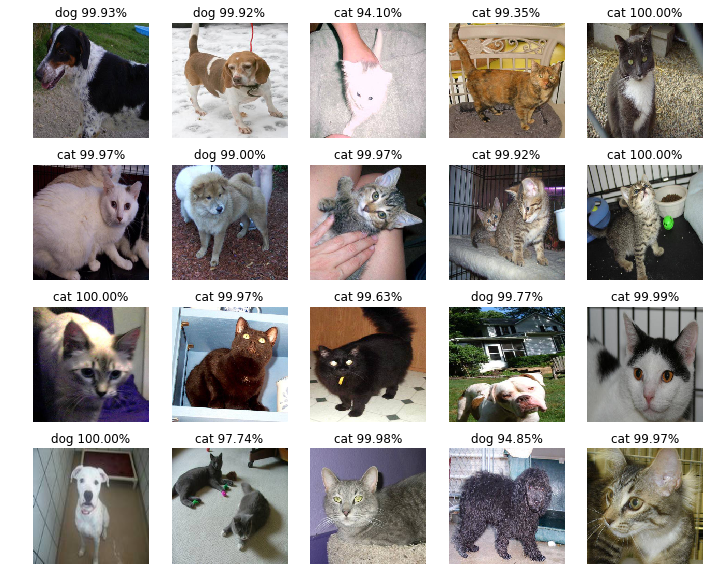

In [11]:
plt.figure(figsize=(12, 10))
for i in range(20):
    x = get_image(random.randint(1, test_num))
    prediction = model.predict(np.expand_dims(x, axis=0))[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(x[:,:,::-1]) # convert BGR to RGB

### Heatmap

In [7]:
print([x.name for x in model.layers], range(len(model.layers)))

['input_1', 'conv1', 'bn_conv1', 'activation_1', 'max_pooling2d_1', 'res2a_branch2a', 'bn2a_branch2a', 'activation_2', 'res2a_branch2b', 'bn2a_branch2b', 'activation_3', 'res2a_branch2c', 'res2a_branch1', 'bn2a_branch2c', 'bn2a_branch1', 'add_1', 'activation_4', 'res2b_branch2a', 'bn2b_branch2a', 'activation_5', 'res2b_branch2b', 'bn2b_branch2b', 'activation_6', 'res2b_branch2c', 'bn2b_branch2c', 'add_2', 'activation_7', 'res2c_branch2a', 'bn2c_branch2a', 'activation_8', 'res2c_branch2b', 'bn2c_branch2b', 'activation_9', 'res2c_branch2c', 'bn2c_branch2c', 'add_3', 'activation_10', 'res3a_branch2a', 'bn3a_branch2a', 'activation_11', 'res3a_branch2b', 'bn3a_branch2b', 'activation_12', 'res3a_branch2c', 'res3a_branch1', 'bn3a_branch2c', 'bn3a_branch1', 'add_4', 'activation_13', 'res3b_branch2a', 'bn3b_branch2a', 'activation_14', 'res3b_branch2b', 'bn3b_branch2b', 'activation_15', 'res3b_branch2c', 'bn3b_branch2c', 'add_5', 'activation_16', 'res3c_branch2a', 'bn3c_branch2a', 'activation_17

In [8]:
len(model.layers)

177

In [9]:
weights = model.layers[176].get_weights()[0]
model2 = Model(model.input, [model.layers[172].output, model.output])

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import random
import cv2

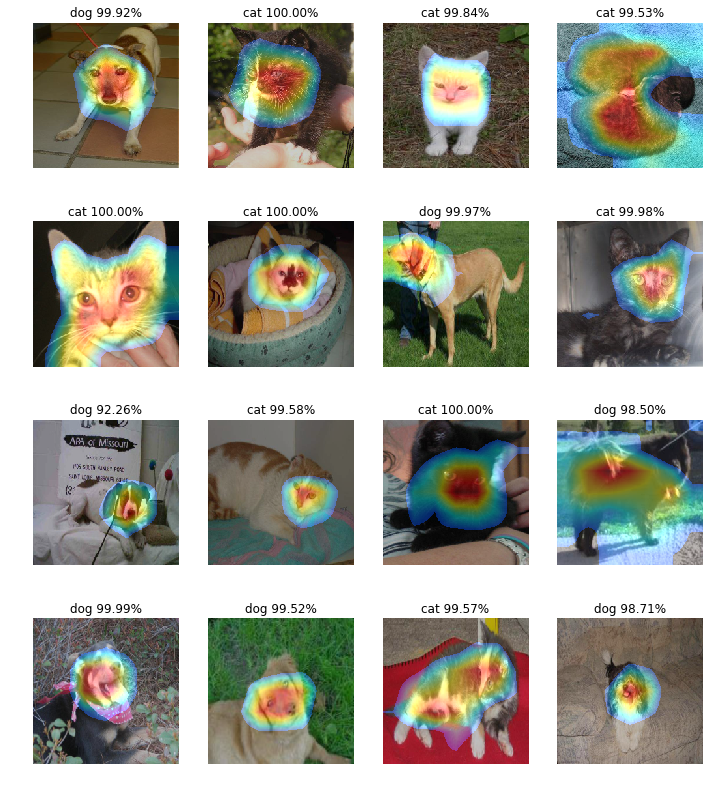

In [15]:
plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('test3/test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])